# Predictiong biochemical activity against 2c9 with a small dataset

In this notebook we will try to use the more representative features of the MACCS fingerprint and the physicochemical descriptors given by Mordred library to fit a model with small dataset.


## Overview

- Load data
- Get fingerprint (in this case we simply load it from files)
- Get descriptors
    - Remove outliers and Normalise data
- Split the data (500 molecules Train + Validation)
- Select data with mutual information score
- DNN
    - Hyperparameters tunning

## 1) Packages

In [134]:
%matplotlib inline
%load_ext tensorboard
!rm -rf ./logs/ 

import os
import random
import numpy as np
import numpy.testing as npt 
import pandas as pd
import tensorflow as tf
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize #, minmax_scale it could also be tried.
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from mordred import Calculator, descriptors

plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0


## 2) Loading data

In [6]:
PATH_DATA = "../datasets/CYP/"

shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [7]:
def col_to_array(df, col_name='p450-cyp2c9 Activity Outcome'):
    col = df[col_name]
    arr = col.to_numpy() # class wants to make reference to active or inactive
    arr = np.reshape(arr, [arr.shape[0],1])
    return np.squeeze(arr)

In [8]:
smi_col_shared = col_to_array(shared_data, 'CanonicalSMILES')
smi_col_only2c9 = col_to_array(testing_2c9_data, 'CanonicalSMILES')

## 3) Get features (RDKit fingerprint)

We need to generate the features for the data sets, we will use RDKit fingerprints as implemented in RDKit.

In [9]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = Chem.RDKFingerprint(mol)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [10]:
if os.path.exists(os.path.join("features", "shared_set_features_RDKIT.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features_RDKIT.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features_RDKIT.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features_RDKIT.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_RDKIT.npy"))
else:   
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features_RDKIT.npy"), features_only_2c9)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features_RDKIT.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_RDKIT.npy"))
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features_RDKIT.npy"), features_only_3a4)

## 4) Getting Mordred descriptors

We generate the descriptors using Mordred if ther are not in the features folder, otherwise the data is loaded from there.

There are two types of data we can load:

- Data without processing: this contains all the physicochemical descriptors that are generated with Mordred.
- Clean data: this data doesn't contains all the descriptors computed by Mordred. All the columns wich contain NaN, are remove to easily apply the feature selection.
    - This data has been processed as follows:
        - Convert all the str in the data frame to NaN.
        - Remove columns that contain NaN values.
            - Note that if we remove rows, we obtain an empty df (-> everything is removed)
        - Remove all the columns with different headers between the shared and only 2c9 datasets.
- Detection and remove of Outliers
- Normalisation

In [11]:
load_clean_data =  True # Otherwise it will load data with NaN
remove_outliers = True
normalize_descriptors = True

In [12]:
def get_descriptors(smi_arr, activity_labels, clean_dataset=True, save_to_npy=True, filename='shared_set_features_mordred'):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in smi_arr]
    df_descriptors = calc.pandas(mols)
    df_descriptors = df_descriptors.insert(0, "p450-cyp2c9 Activity Outcome", activity_labels, True)
    if clean_dataset:
        df_descriptors = descriptors_shared.apply(pd.to_numeric, errors='coerce')
        df_descriptors = df_descriptors.dropna(axis=1)
    if save_to_npy:
        df_descriptors.to_csv(os.path.join("features", filename + ".npy"))
    return df_descriptors

In [13]:
if load_clean_data:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred_clean.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=True, filename='shared_set_features_mordred_clean')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred_clean.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=True, filename='only2c9_features_mordred_clean')

else:
    if os.path.exists(os.path.join("features", "shared_set_features_mordred.npy")):
        descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_shared = get_descriptors(smi_col_shared, labels_2c9, clean_dataset=False, filename='shared_set_features_mordred')

    if os.path.exists(os.path.join("features", "only2c9_features_mordred.npy")):
        descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred.npy")).drop(['Unnamed: 0'], axis=1)
    else:
        descriptors_only2c9 = get_descriptors(smi_col_only2c9, labels_testing_2c9, clean_dataset=False, filename='only2c9_features_mordred')

In [14]:
if load_clean_data: # To get data with the same descriptors
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [15]:
print(descriptors_shared.shape, descriptors_only2c9.shape)

(9420, 752) (2813, 752)


### 4.1) Detection and remove of Outliers

Before selecting features, we will remove the examples that contain outliers using the Z score criteria.

$Z = \frac{X-\mu}{\sigma}$

Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean. [Source](https://statisticsbyjim.com/basics/outliers/)

In [16]:
def compute_z_score(df_original):
    df=df_original.copy()
    headers = []
    for col in df.columns:
        df[f'{col}_zscore'] = (df[col] - df[col].mean())/df[col].std(ddof=0)
        headers.append(col)
    return df, headers

def outliers_detection(df, threshold=3):
    df_scored, headers=compute_z_score(df)
    zscore_col = list(set(df_scored.columns) - set(headers)) # to only evaluate zscore columns
    for col in zscore_col:
        df_scored[f'{col}_outlier'] = (abs(df_scored[f'{col}'])> threshold).astype(int)
    return df_scored, zscore_col

def drop_outliers(df, threshold=3):
    df_outlier, zscore_col = outliers_detection(df, threshold=threshold)
    for col in zscore_col:
        index = df_outlier[ df_outlier[f'{col}_outlier'] == 1 ].index
        df_outlier.drop(index , inplace=True)
        df_outlier.drop(col , inplace=True,axis = 1)
        df_outlier.drop(f'{col}_outlier' , inplace=True, axis = 1)
    return df_outlier

Note that in this cell we remove the molecules which contain descriptors' outliers in the fingerprint dataset.

In [17]:
if remove_outliers:
    threshold = 3
    if not os.path.exists(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy")):
        descriptors_shared = drop_outliers(descriptors_shared, threshold=threshold)
        descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))   
    descriptors_shared = pd.read_csv(os.path.join("features", "shared_set_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_shared['Unnamed: 0'])
    features_shared = features_shared[loc,:]
    descriptors_shared = descriptors_shared.drop(['Unnamed: 0'], axis=1)
  
    if not os.path.exists(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy")):
        descriptors_only2c9 = drop_outliers(descriptors_only2c9, threshold=threshold)
        descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9 = pd.read_csv(os.path.join("features", "only2c9_features_mordred_clean_no_outliers.npy"))
    loc = list(descriptors_only2c9['Unnamed: 0'])
    features_only_2c9 = features_only_2c9[loc,:]
    descriptors_only2c9 = descriptors_only2c9.drop(['Unnamed: 0'], axis=1)
    
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [18]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

In [21]:
if remove_outliers and not descriptors_only2c9.shape[1] == descriptors_shared.shape[1]:
    lst_shared_clean=list(descriptors_shared.columns.values)
    lst_only2c9_clean=list(descriptors_only2c9.columns.values)
    common_elements=list(set(lst_shared_clean) & set(lst_only2c9_clean))

    lst_shared_clean = list(set(lst_shared_clean)-set(common_elements))
    lst_only2c9_clean = list(set(lst_only2c9_clean)-set(common_elements))
    
    descriptors_shared = descriptors_shared.drop(lst_shared_clean, axis=1)
    descriptors_only2c9 = descriptors_only2c9.drop(lst_only2c9_clean, axis=1)
    
    descriptors_shared.to_csv(os.path.join("features", 'shared_set_features_mordred_clean_no_outliers.npy'))
    descriptors_only2c9.to_csv(os.path.join("features", 'only2c9_features_mordred_clean_no_outliers.npy'))
    
    labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
    labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

    
labels_2c9 = np.array(descriptors_shared['p450-cyp2c9 Activity Outcome'])
labels_testing_2c9 = np.array(descriptors_only2c9['p450-cyp2c9 Activity Outcome'])

assert descriptors_shared.shape[0] == labels_2c9.shape[0]
assert descriptors_only2c9.shape[0] == labels_testing_2c9.shape[0]
assert descriptors_shared.shape[1] == descriptors_only2c9.shape[1]

In [22]:
descriptors_shared.shape, descriptors_only2c9.shape

((2372, 752), (846, 752))

### 4.2) Normalisation

Now we are going to normalise each feature of the dataset to values between [0,1]

In [23]:
norm_descriptors_shared = pd.DataFrame(normalize(descriptors_shared, norm='max', axis=0))
norm_descriptors_only2c9 = pd.DataFrame(normalize(descriptors_only2c9, norm='max', axis=0))

## 5) Feature selection and cross validation

In this part we want to select the descriptors and the fingerprint features that are very representative of the molecule activity.
However, as we want to simulate what happens in a small dataset, the best features will be selected with the training set after splitting the data.
The training set will consist in a small dataset.

Here we propose two ways in how it can be done the feature selection and the cross validation:

### A)

In this case, for each train/val split, we're going to find the best parameters and, subsequently, carry out the validation of the model.

- Generate 15 random numbers that are going to be used as seeds for the splitting of the train/val datasets.
    - It is important to save this random numbers, because they are going to be used for the cross validation.
- Split the train and validation set many times (15 times) to reduce the possibiity of having a wierd split.
    - Selection of the best features for each split, and save them.
    - Fit and predict on the validation (CV).
- Select the most important features (i.e. the more repeated) using the best features we collect when splitting.
- With the most important features, fit the model (with all the train + validation set) and predict on the test set.

### B)

In this case, we'll find the features that are useful for each split and then, select the ones that are more relevant. 
With the most relevant features, we'll do the cross validation

#### B1) Best features selection
- Generate 15 random numbers that are going to be used as seeds for the splitting of the train/val datasets.
    - It is important to save this random numbers, because they are going to be used for the cross validation.
- Split the train and validation set many times (15 times) to reduce the possibiity of having a wierd split.
    - Selection of the best features for each split.
- Select the best features considering the best features for each split
    - To do so, we'll use a consensus function (most repeated).

#### B2) Validation model with the best features


#### B3) Predicction

In the following cell there are the percentage of values that are kept of the descriptors.
Since the fingerprint seems to have a low score in all its features (see plots below), a lower percentil was selected in order to avoid 'noise'.

In [48]:
# Percentage to be kept
percetile_descriptors = 60
percetile_fingerprint = 60 #40

use_fingerprints = True # if true -> fingerpornts are used.
use_descriptors = True # if true -> descriptors are used.

if use_fingerprints and not use_descriptors:
    print("Only fingerprints are going to be used.")
elif use_descriptors and not use_fingerprints:     
    print("Only descriptors are going to be used.")
elif use_fingerprints and use_descriptors:
    print("Fingerprints and descriptors are going to be used (concatenated).")

Fingerprints and descriptors are going to be used (concatenated).


In [34]:
# Drop the first column which contain the chemical activity against 2c9
norm_descriptors_shared = norm_descriptors_shared.drop([0], axis=1)
norm_descriptors_only2c9 = norm_descriptors_only2c9.drop([0], axis=1)
                                                       
assert features_shared.shape[0] == norm_descriptors_shared.shape[0]
assert features_only_2c9.shape[0] == norm_descriptors_only2c9.shape[0]

KeyError: '[0] not found in axis'

In [ ]:
train_data = np.asarray(train_data).astype(np.float32)
val_data = np.asarray(val_data).astype(np.float32)

In [87]:
norm_descriptors_shared = np.asarray(norm_descriptors_shared).astype(np.float32) # to avoid problems with the KFoldCrossValidation

Ara aqui tinc 4 llistes, 2 de fingerprints i 2 de descriptors.

- features_shared
- features_only_2c9 -> Aquesta no la toco de moment perque sera el meu test.

//

- norm_descriptors_shared
- norm_descriptors_only2c9 -> Aquesta no la toco de moment perque sera el meu test.

Ja tenim la funcio que permet trobar les millors features per cada split. Aquesta funció es comuna en les dues methodologies.

El següent pas és implementar les coses.

Ara vull: (després s'ha de posar en un for loop que itera amb seeds)
    
- un cop torna les dades, cal concatenar train fp i des (similarment amb els validation set). AIXÒ NOMÉS SERIA PEL METODE A). PEL B) CALDRIA GUARDAR LES SEEDS.

In [101]:
def split_features(features, labels, train_size=450, val_size=50, seed=1, plot_distribution=False):
    train_data, val_data, train_labels, val_labels = train_test_split(features, labels, train_size=train_size, test_size=val_size, stratify=labels, random_state=seed)

    if plot_distribution:
        fig, ax = plt.subplots(1, 2, figsize=(14,10))
        ax[0].hist(train_labels)
        ax[0].set_xlabel("Training set 2c9")
        ax[1].hist(val_labels)
        ax[1].set_xlabel("Validation set 2c9")
        plt.subplots_adjust(wspace=0.5)
        plt.show()
    
    return {'train_data':train_data, 'val_data':val_data, 'train_labels':train_labels, 'val_labels':val_labels}


def select_features(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentile.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    

def get_best_features_index(fs):
    """Returns a numpy array with the indexs of the best features."""
    mask = fs.get_support()
    best_features_tup = np.where(mask == True)
    
    return best_features_tup[0] 



#pa fuera?
def get_best_features_per_split(features, labels, percetile_fingerprint=60, percetile_descriptors=60, train_size=450, val_size=50, seed=1, plot_distribution=False):
    """Splits the data and find the best features"""
    data = split_features(features, labels, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
    train_data, val_data, fs = select_features(data['train_data'], data['train_labels'], data['val_data'], score_func=mutual_info_classif, percentile = percetile_fingerprint)
    best_features = get_best_features_index(fs)
    
    assert train_data.shape[1] == val_data.shape[1]
    assert train_data.shape[1] == best_features.shape[0]
    
    return {'train_data_fs':train_data, 'val_data_fs':val_data, 'train_labels':data['train_labels'], 'val_labels':data['val_labels']}, best_features

#pa fuera?
def select_feat_and_get_best_feat_per_split(use_fingerprints, use_descriptors, fp_data=None,
                                            descriptors_data=None, labels=None, percetile_fingerprint=60, 
                                            percetile_descriptors=60, train_size=450, val_size=50, seed=1, 
                                            plot_distribution=False):
    if use_fingerprints:
        data_fs_fp, best_feat_index_fp = get_best_features_per_split(fp_data, labels, percetile_fingerprint=percetile_fingerprint, percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
    if use_descriptors:
        data_fs_des, best_feat_index_des = get_best_features_per_split(descriptors_data, labels, percetile_fingerprint=percetile_fingerprint, percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, plot_distribution=plot_distribution)
    if use_descriptors and use_fingerprints:
        npt.assert_array_equal(data_fs_fp['train_labels'], data_fs_des['train_labels'], err_msg='Train labels do not coincide between descriptors and fingerprints.')
        npt.assert_array_equal(data_fs_fp['val_labels'], data_fs_des['val_labels'], err_msg='Validation labels do not coincide between descriptors and fingerprints.')
        assert data_fs_fp['train_data_fs'].shape[0] == data_fs_des['train_data_fs'].shape[0]
        assert data_fs_fp['val_data_fs'].shape[0] == data_fs_des['val_data_fs'].shape[0]
    return data_fs_fp, data_fs_des, best_feat_index_fp, best_feat_index_des

#pa fuera?
def split_dataset(full_set, labels_full_set, set_size, seed=1):
    np.random.seed(seed)
    m_set = full_set.shape[0] # number of examples in the full set
    permutation_set = list(np.random.permutation(m_set))
    shuffled_data = full_set[permutation_set,:]
    shuffled_labels = labels_full_set[permutation_set]
    mini_set = shuffled_data[:set_size,:]
    mini_labels_set = shuffled_labels[:set_size].reshape(set_size,1)
    return mini_set, mini_labels_set

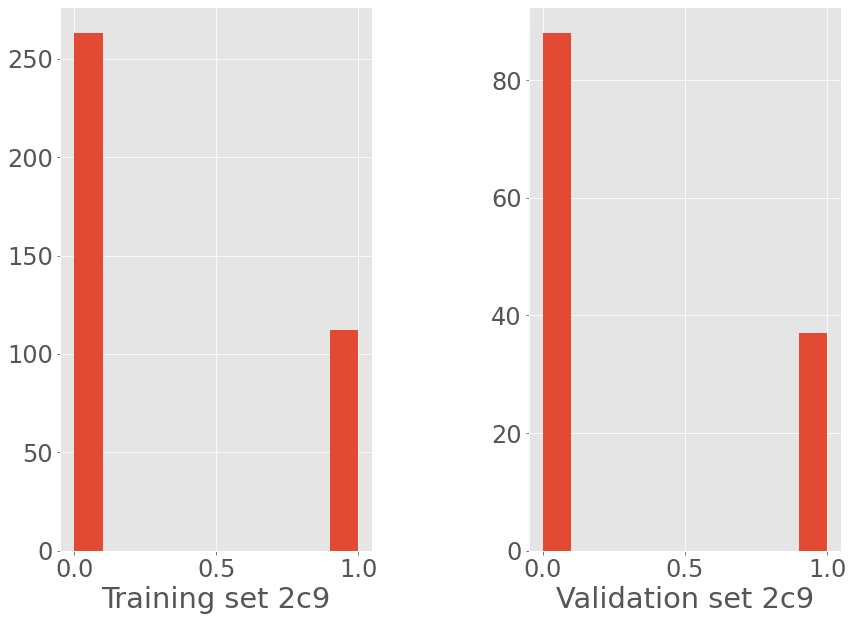

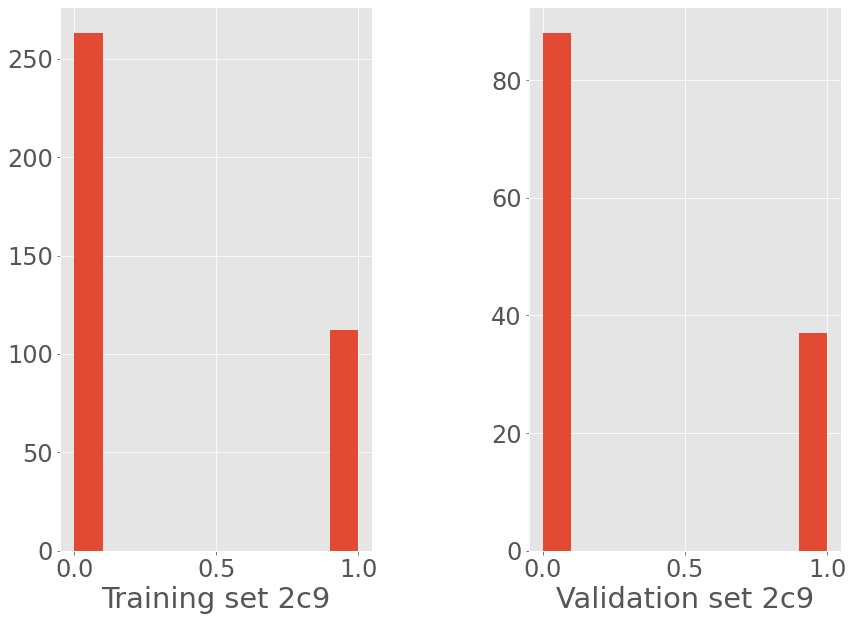

In [46]:
dataset_size = 500                  # training + validation sets
train_size = int(0.75 * dataset_size)
val_size = int(0.25 * dataset_size)
plot_distribution = True
seed=1

data_fs_fp, data_fs_des, best_feat_index_fp, best_feat_index_des = select_feat_and_get_best_feat_per_split(use_fingerprints, use_descriptors, fp_data=features_shared,
                                                                    descriptors_data=norm_descriptors_shared, labels=labels_2c9, percetile_fingerprint=60, 
                                                                    percetile_descriptors=percetile_descriptors, train_size=train_size, val_size=val_size, seed=seed, 
                                                                    plot_distribution=plot_distribution)

### 5.A)

In [103]:
def select_features(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentile.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs


def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    

def get_best_features_index(fs):
    """Returns a numpy array with the indexs of the best features."""
    mask = fs.get_support()
    best_features_tup = np.where(mask == True)
    
    return best_features_tup[0] 


def get_best_features(train_data, train_labels, val_data, percentile):
    """calculates score fuction of the features and returns the best features"""
    train_data, val_data, fs = select_features(train_data, train_labels, val_data, score_func=mutual_info_classif, percentile = percentile)
    best_features = get_best_features_index(fs)
    
    assert train_data.shape[1] == val_data.shape[1]
    assert train_data.shape[1] == best_features.shape[0]
    
    return {'train_data_fs':train_data, 'val_data_fs':val_data}, best_features

In [142]:
def generate_model(layers_dim, lr, dropout, optimizer, L2):
    """layers_dim -- [n_input, n_hid_1, ..., n_output=1]"""
    hidden_layers = []
    for i in range(1,len(layers_dim)-1): hidden_layers.extend([tf.keras.layers.Dropout(dropout)] + [tf.keras.layers.Dense(layers_dim[i], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2))])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(layers_dim[0], activation='relu', input_shape=(layers_dim[0],))] +
        hidden_layers + 
        [tf.keras.layers.Dense(layers_dim[-1], activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 
    return model

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    f1 = f1_score(target_values, predicted_values >= 0.5, average='binary')
    balanced_accuracy = balanced_accuracy_score(target_values, predicted_values >= 0.5, sample_weight=None, adjusted=True)
    
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}, F1 score: {f1:.3f}, Balanced accuracy: {balanced_accuracy:.3f}")
    return {'accuracy': accuracy, 'precision': precision, 'recall': Sn, 'specificity':Sp, 'mcc':mcc, 'ner':ner, 'f1':f1, 'balanced_accuracy':balanced_accuracy}


def plot_results_CV(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val):
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    y_min = -0.1+np.nanmin([np.nanmin(balanced_acc_train), np.nanmin(balanced_acc_val), np.nanmin(F1_train), np.nanmin(F1_val), np.nanmin(accs_train), np.nanmin(accs_val),np.nanmin(accs_test), np.nanmin(MCCs_train), np.nanmin(MCCs_val), np.nanmin(MCCs_test), np.nanmin(recall_train), np.nanmin(recall_val), np.nanmin(recall_test), np.nanmin(precision_train), np.nanmin(precision_val), np.nanmin(precision_test)])
    y_max = 0.1+np.nanmax([np.nanmax(balanced_acc_train), np.nanmax(balanced_acc_val), np.nanmax(F1_train), np.nanmax(F1_val), np.nanmax(accs_train), np.nanmax(accs_val), np.nanmax(accs_test), np.nanmax(MCCs_train), np.nanmax(MCCs_val), np.nanmax(MCCs_test), np.nanmax(recall_train), np.nanmax(recall_val), np.nanmax(recall_test), np.nanmax(precision_train), np.nanmax(precision_val), np.nanmax(precision_test)])
    ax[0, 0].boxplot([np.array(accs_train)[~np.isnan(accs_train)], np.array(accs_val)[~np.isnan(accs_val)]], labels=["Train", "Val"])
    ax[0, 1].boxplot([np.array(recall_train)[~np.isnan(recall_train)], np.array(recall_val)[~np.isnan(recall_val)]], labels=["Train", "Val"])
    ax[0, 2].boxplot([np.array(precision_train)[~np.isnan(precision_train)], np.array(precision_val)[~np.isnan(precision_val)], np.array(precision_test)[~np.isnan(precision_test)]], labels=["Train", "Val", "Test"]) 
    ax[1, 0].boxplot([np.array(balanced_acc_train)[~np.isnan(balanced_acc_train)], np.array(balanced_acc_val)[~np.isnan(balanced_acc_val)]], labels=["Train", "Val"])
    ax[1, 1].boxplot([np.array(F1_train)[~np.isnan(F1_train)], np.array(F1_val)[~np.isnan(F1_val)]], labels=["Train", "Val"])
    ax[1, 2].boxplot([np.array(MCCs_train)[~np.isnan(MCCs_train)], np.array(MCCs_val)[~np.isnan(MCCs_val)]], labels=["Train", "Val"])
    ax[0, 0].set_ylim(top=y_max, bottom=y_min)
    ax[0, 1].set_ylim(top=y_max, bottom=y_min)
    ax[1, 0].set_ylim(top=y_max, bottom=y_min)
    ax[1, 1].set_ylim(top=y_max, bottom=y_min)
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 1].set_ylabel("Recall")
    ax[0, 2].set_ylabel("Precision")
    ax[1, 0].set_ylabel("Balanced Accuracy")
    ax[1, 1].set_ylabel("F1")
    ax[1, 2].set_ylabel("MCC")
    
    plt.tight_layout()
    plt.show()

In [140]:
dataset_size = 500                  # training + validation sets
train_size = int(0.75 * dataset_size)
val_size = int(0.25 * dataset_size)
plot_distribution = True
seed = 1
num_train_val_splits = 15
folds = 10 # Number of folds in cross-validation

layers_dim = [30,30,30,30, 1] #excluding the input layer
lr = 0.01
dropout = 0.2
optimizer = 'sgd'
L2 = 0.001


np.random.seed(seed) # set a numpy seed
rand_num = np.random.randint(10000, size=num_train_val_splits)

Ara cal:

- Guardar les millors features per cada fold
- Seleccionar les features més importants = les que apareixen mes els seus index
    - cal anar amb compte perque s'han de seleccionar el mateix num de features bones.
- per cada split, fer predict del test
    - cal guardar somehow les metriques del validation.
    - es podria no posar la metrica del test.


Calculating with fold 0


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0
 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1
 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0
 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0
 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1
 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0
 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0
 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8443 - accuracy: 0.4311 - precision_3: 0.3138 - recall_3: 0.7556 - val_loss: 0.8182 - val_accuracy: 0.4800 - val_precision_3: 0.3125 - val_recall_3: 0.7143
Epoch 2/10
450/450 - 1s - loss: 0.8483 - accuracy: 0.4200 - precision_3: 0.2842 - recall_3: 0.6148 - val_loss: 0.8143 - val_accuracy: 0.6800 - val_precision_3: 0.4583 - val_recall_3: 0.7857
Epoch 3/10
450/450 - 3s - loss: 0.8380 - accuracy: 0.4444 - precision_3: 0.2968 - recall_3: 0.6222 - val_loss: 0.8153 - val_accuracy: 0.7000 - val_precision_3: 0.4545 - val_recall_3: 0.3571
Epoch 4/10
450/450 - 4s - loss: 0.8413 - accuracy: 0.4356 - precision_3: 0.3010 - recall_3: 0.6667 - val_loss: 0.8086 - val_accuracy: 0.4200 - val_precision_3: 0.3256 - val_recall_3: 1.0000
Epoch 5/10
450/450 - 4s - loss: 0.8287 - accuracy: 0.4311 - precision_3: 0.3150 - recall_3: 0.7630 - val_loss: 0.8090 - val_accuracy: 0.4400 - val_precision_3: 0.3333 - val_recall_3: 1.0000
Epoch

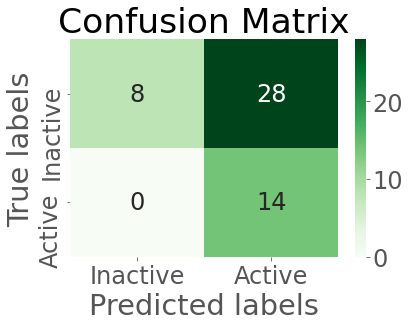

Calculating with fold 1


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0
 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0
 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0
 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0
 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0
 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0
 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0
 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8438 - accuracy: 0.4333 - precision_4: 0.2921 - recall_4: 0.6343 - val_loss: 0.8438 - val_accuracy: 0.3400 - val_precision_4: 0.3125 - val_recall_4: 1.0000
Epoch 2/10
450/450 - 1s - loss: 0.8424 - accuracy: 0.4578 - precision_4: 0.3090 - recall_4: 0.6642 - val_loss: 0.8414 - val_accuracy: 0.3200 - val_precision_4: 0.3061 - val_recall_4: 1.0000
Epoch 3/10
450/450 - 1s - loss: 0.8409 - accuracy: 0.4800 - precision_4: 0.3239 - recall_4: 0.6866 - val_loss: 0.8410 - val_accuracy: 0.5200 - val_precision_4: 0.3846 - val_recall_4: 1.0000
Epoch 4/10
450/450 - 1s - loss: 0.8416 - accuracy: 0.4600 - precision_4: 0.3018 - recall_4: 0.6194 - val_loss: 0.8403 - val_accuracy: 0.6200 - val_precision_4: 0.4412 - val_recall_4: 1.0000
Epoch 5/10
450/450 - 1s - loss: 0.8403 - accuracy: 0.4756 - precision_4: 0.3008 - recall_4: 0.5746 - val_loss: 0.8398 - val_accuracy: 0.5200 - val_precision_4: 0.3846 - val_recall_4: 1.0000
Epoch

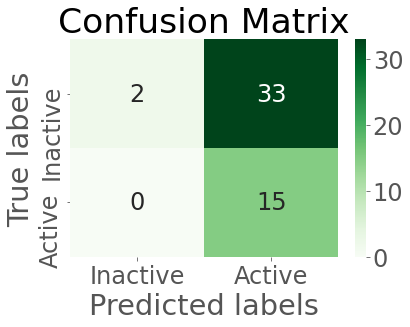

Calculating with fold 2


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0
 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1
 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1
 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 0.8523 - accuracy: 0.6600 - precision_5: 0.2791 - recall_5: 0.0896 - val_loss: 0.8362 - val_accuracy: 0.5800 - val_precision_5: 0.3846 - val_recall_5: 0.6667
Epoch 2/10
450/450 - 1s - loss: 0.8380 - accuracy: 0.6133 - precision_5: 0.3214 - recall_5: 0.2687 - val_loss: 0.8350 - val_accuracy: 0.4800 - val_precision_5: 0.3429 - val_recall_5: 0.8000
Epoch 3/10
450/450 - 1s - loss: 0.8381 - accuracy: 0.6133 - precision_5: 0.3507 - recall_5: 0.3507 - val_loss: 0.8324 - val_accuracy: 0.4800 - val_precision_5: 0.3590 - val_recall_5: 0.9333
Epoch 4/10
450/450 - 1s - loss: 0.8340 - accuracy: 0.5622 - precision_5: 0.3351 - recall_5: 0.4776 - val_loss: 0.8279 - val_accuracy: 0.5400 - val_precision_5: 0.3824 - val_recall_5: 0.8667
Epoch 5/10
450/450 - 1s - loss: 0.8369 - accuracy: 0.5667 - precision_5: 0.3315 - recall_5: 0.4478 - val_loss: 0.8257 - val_accuracy: 0.5000 - val_precision_5: 0.3750 - val_recall_5: 1.0000
Epoch

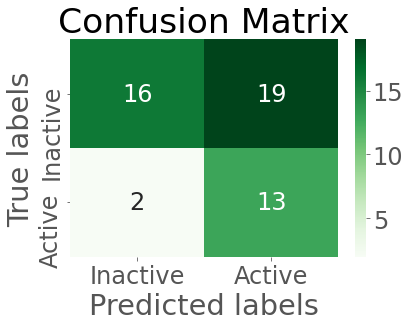

Calculating with fold 3


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0
 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0
 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1
 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0
 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0
 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 0.8694 - accuracy: 0.5067 - precision_6: 0.2349 - recall_6: 0.2910 - val_loss: 0.8568 - val_accuracy: 0.5400 - val_precision_6: 0.2500 - val_recall_6: 0.2667
Epoch 2/10
450/450 - 1s - loss: 0.8540 - accuracy: 0.5511 - precision_6: 0.2792 - recall_6: 0.3209 - val_loss: 0.8377 - val_accuracy: 0.3000 - val_precision_6: 0.2727 - val_recall_6: 0.8000
Epoch 3/10
450/450 - 1s - loss: 0.8474 - accuracy: 0.4689 - precision_6: 0.3063 - recall_6: 0.6194 - val_loss: 0.8329 - val_accuracy: 0.3200 - val_precision_6: 0.2979 - val_recall_6: 0.9333
Epoch 4/10
450/450 - 1s - loss: 0.8523 - accuracy: 0.4444 - precision_6: 0.2914 - recall_6: 0.6045 - val_loss: 0.8309 - val_accuracy: 0.3400 - val_precision_6: 0.3125 - val_recall_6: 1.0000
Epoch 5/10
450/450 - 1s - loss: 0.8311 - accuracy: 0.4911 - precision_6: 0.3333 - recall_6: 0.7090 - val_loss: 0.8285 - val_accuracy: 0.3200 - val_precision_6: 0.3061 - val_recall_6: 1.0000
Epoch

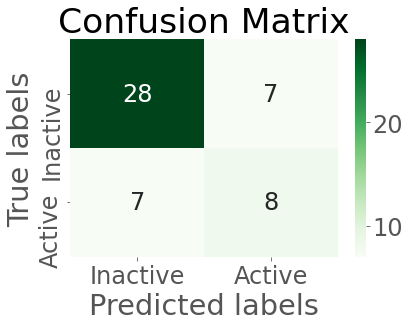

Calculating with fold 4


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1
 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0
 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1
 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 4s - loss: 0.8432 - accuracy: 0.5000 - precision_7: 0.3202 - recall_7: 0.6045 - val_loss: 0.8355 - val_accuracy: 0.5800 - val_precision_7: 0.3636 - val_recall_7: 0.5333
Epoch 2/10
450/450 - 1s - loss: 0.8443 - accuracy: 0.4800 - precision_7: 0.2881 - recall_7: 0.5075 - val_loss: 0.8346 - val_accuracy: 0.5800 - val_precision_7: 0.3846 - val_recall_7: 0.6667
Epoch 3/10
450/450 - 1s - loss: 0.8404 - accuracy: 0.5022 - precision_7: 0.3026 - recall_7: 0.5149 - val_loss: 0.8347 - val_accuracy: 0.6600 - val_precision_7: 0.4500 - val_recall_7: 0.6000
Epoch 4/10
450/450 - 1s - loss: 0.8409 - accuracy: 0.5333 - precision_7: 0.3041 - recall_7: 0.4403 - val_loss: 0.8339 - val_accuracy: 0.6400 - val_precision_7: 0.4118 - val_recall_7: 0.4667
Epoch 5/10
450/450 - 1s - loss: 0.8402 - accuracy: 0.5111 - precision_7: 0.3114 - recall_7: 0.5299 - val_loss: 0.8290 - val_accuracy: 0.6000 - val_precision_7: 0.4242 - val_recall_7: 0.9333
Epoch

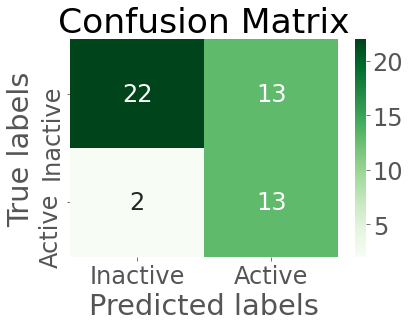

Calculating with fold 5


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0
 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1
 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0
 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0
 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0
 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8396 - accuracy: 0.5733 - precision_8: 0.3424 - recall_8: 0.4701 - val_loss: 0.8353 - val_accuracy: 0.4000 - val_precision_8: 0.3256 - val_recall_8: 0.9333
Epoch 2/10
450/450 - 1s - loss: 0.8412 - accuracy: 0.4956 - precision_8: 0.3054 - recall_8: 0.5448 - val_loss: 0.8300 - val_accuracy: 0.3800 - val_precision_8: 0.3095 - val_recall_8: 0.8667
Epoch 3/10
450/450 - 1s - loss: 0.8337 - accuracy: 0.5422 - precision_8: 0.3475 - recall_8: 0.6119 - val_loss: 0.8306 - val_accuracy: 0.3400 - val_precision_8: 0.3125 - val_recall_8: 1.0000
Epoch 4/10
450/450 - 1s - loss: 0.8380 - accuracy: 0.4956 - precision_8: 0.3284 - recall_8: 0.6642 - val_loss: 0.8351 - val_accuracy: 0.3800 - val_precision_8: 0.3095 - val_recall_8: 0.8667
Epoch 5/10
450/450 - 1s - loss: 0.8379 - accuracy: 0.4889 - precision_8: 0.3140 - recall_8: 0.6045 - val_loss: 0.8380 - val_accuracy: 0.5600 - val_precision_8: 0.2941 - val_recall_8: 0.3333
Epoch

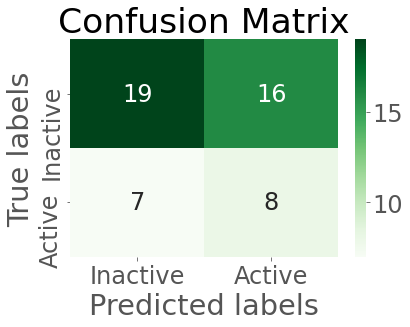

Calculating with fold 6


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0
 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1
 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0
 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1
 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1
 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 0.8433 - accuracy: 0.6244 - precision_9: 0.2941 - recall_9: 0.1866 - val_loss: 0.8463 - val_accuracy: 0.5800 - val_precision_9: 0.2000 - val_recall_9: 0.1333
Epoch 2/10
450/450 - 1s - loss: 0.8405 - accuracy: 0.6333 - precision_9: 0.3604 - recall_9: 0.2985 - val_loss: 0.8454 - val_accuracy: 0.4800 - val_precision_9: 0.1765 - val_recall_9: 0.2000
Epoch 3/10
450/450 - 1s - loss: 0.8422 - accuracy: 0.5911 - precision_9: 0.3311 - recall_9: 0.3657 - val_loss: 0.8444 - val_accuracy: 0.5400 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 4/10
450/450 - 1s - loss: 0.8414 - accuracy: 0.5978 - precision_9: 0.2673 - recall_9: 0.2015 - val_loss: 0.8450 - val_accuracy: 0.5400 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00
Epoch 5/10
450/450 - 1s - loss: 0.8396 - accuracy: 0.6200 - precision_9: 0.2967 - recall_9: 0.2015 - val_loss: 0.8436 - val_accuracy: 0.6800 - val_precision_9: 0.3333 - val_recall

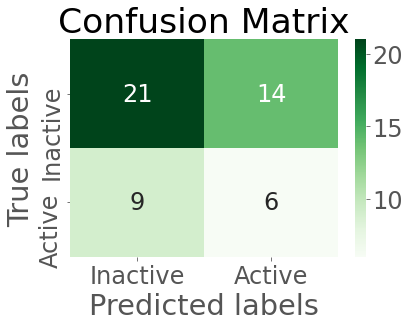

Calculating with fold 7


/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1
 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0
 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0
 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 

Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8574 - accuracy: 0.5667 - precision_10: 0.3082 - recall_10: 0.3657 - val_loss: 0.8583 - val_accuracy: 0.6000 - val_precision_10: 0.3077 - val_recall_10: 0.2667
Epoch 2/10
450/450 - 1s - loss: 0.8363 - accuracy: 0.5600 - precision_10: 0.3298 - recall_10: 0.4627 - val_loss: 0.8427 - val_accuracy: 0.3400 - val_precision_10: 0.2857 - val_recall_10: 0.8000
Epoch 3/10
450/450 - 1s - loss: 0.8372 - accuracy: 0.5111 - precision_10: 0.3320 - recall_10: 0.6343 - val_loss: 0.8440 - val_accuracy: 0.3400 - val_precision_10: 0.3043 - val_recall_10: 0.9333
Epoch 4/10
450/450 - 1s - loss: 0.8360 - accuracy: 0.5044 - precision_10: 0.3308 - recall_10: 0.6493 - val_loss: 0.8434 - val_accuracy: 0.3000 - val_precision_10: 0.3000 - val_recall_10: 1.0000
Epoch 5/10
450/450 - 1s - loss: 0.8240 - accuracy: 0.4867 - precision_10: 0.3441 - recall_10: 0.7985 - val_loss: 0.8482 - val_accuracy: 0.3000 - val_precision_10: 0.3000 - val_rec

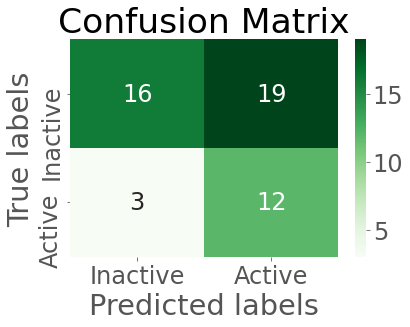

KeyboardInterrupt: 

In [143]:
for split, seed in enumerate(rand_num):
    if use_fingerprints:
        train_val_data_fp, _, train_val_labels_fp, _ = train_test_split(features_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors:
        train_val_data_des, _, train_val_labels_des, _ = train_test_split(norm_descriptors_shared, labels_2c9, train_size=dataset_size, test_size=2, stratify=labels_2c9, random_state=seed)
    if use_descriptors and use_fingerprints:
        npt.assert_array_equal(train_val_labels_fp, train_val_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
        assert train_val_data_fp.shape[0] == train_val_data_des.shape[0]
       
    best_features_split_fp, best_features_split_des = [], []
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    MCCs_train, MCCs_val = [],[]
    accs_train, accs_val= [],[]
    recall_train, recall_val = [],[]
    precision_train, precision_val = [],[]
    F1_train, F1_val = [],[]
    balanced_acc_train, balanced_acc_val = [],[]
    
    for i, (train_index, val_index) in enumerate(skf.split(train_val_data_fp, train_val_labels_fp)):
        if use_fingerprints:
            train_data_fp, val_data_fp = train_val_data_fp[train_index], train_val_data_fp[val_index]
            train_labels_fp, val_labels_fp = train_val_labels_fp[train_index], train_val_labels_fp[val_index]
            data_fs_fp, best_fold_fp = get_best_features(train_data_fp, train_labels_fp, val_data_fp, percetile_fingerprint)
                        
            assert train_data_fp.shape[1] == val_data_fp.shape[1]
            assert train_data_fp.shape[0] == train_labels_fp.shape[0]
            assert val_data_fp.shape[0] == val_labels_fp.shape[0]
                       
            if not use_descriptors: # to avoid conditional statements
                train_data, val_data = data_fs_fp['train_data_fs'], data_fs_fp['val_data_fs']
                train_labels, val_labels = train_labels_fp, val_labels_fp
        
        if use_descriptors:
            train_data_des, val_data_des = train_val_data_des[train_index], train_val_data_des[val_index]
            train_labels_des, val_labels_des = train_val_labels_des[train_index], train_val_labels_des[val_index]
            data_fs_des, best_fold_des = get_best_features(train_data_des, train_labels_des, val_data_des, percetile_descriptors)
            
            assert train_data_des.shape[1] == val_data_des.shape[1]
            assert train_data_des.shape[0] == train_labels_des.shape[0]
            assert val_data_des.shape[0] == val_labels_des.shape[0]
            
            if not use_fingerprints:
                train_data, val_data = data_fs_des['train_data_fs'], data_fs_des['val_data_fs']
                train_labels, val_labels = train_labels_des, val_labels_des
                
        if use_descriptors and use_fingerprints:
            npt.assert_array_equal(train_labels_fp, train_labels_des, err_msg='Train labels do not coincide between descriptors and fingerprints.')
            npt.assert_array_equal(val_labels_fp, val_labels_des, err_msg='Validation labels do not coincide between descriptors and fingerprints.')
            assert data_fs_fp['train_data_fs'].shape[0] == data_fs_des['train_data_fs'].shape[0]
            assert data_fs_fp['val_data_fs'].shape[0] == data_fs_des['val_data_fs'].shape[0]
 
            train_labels, val_labels = train_labels_des, val_labels_des
            
            train_data = np.concatenate([data_fs_fp['train_data_fs'], data_fs_des['train_data_fs']], axis=1)
            val_data = np.concatenate([data_fs_fp['val_data_fs'], data_fs_des['val_data_fs']], axis=1)
                
        print(f"Calculating with fold {i}")
       
        if not layers_dim[0] == train_data.shape[1]:
            layers_dim.insert(0, train_data.shape[1])
            print(type(layers_dim))

        class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
        class_weight = {0: class_weights[0], 1: class_weights[1]}
        
        model = generate_model(layers_dim, lr, dropout, optimizer, L2)
        # si hi ha una llista de models, es podria fer for loop de model in models
        history = model.fit(train_data, train_labels, epochs=10, verbose=2, validation_data = (val_data, val_labels), class_weight=class_weight)
      
        pred_train = model.predict(train_data)
        dict_train = print_metrics(pred_train, train_labels)
        train_acc, train_mcc, train_recall, train_precision, train_f1, train_balanced_acc = dict_train['accuracy'], dict_train['mcc'],  dict_train['recall'],  dict_train['precision'], dict_train['f1'], dict_train['balanced_accuracy']

        pred_val = model.predict(val_data)
        print(f"---> Validation set fold {i}")
        dict_val = print_metrics(pred_val, val_labels)
        val_acc, val_mcc, val_recall, val_precision, val_f1, val_balanced_acc  = dict_val['accuracy'], dict_val['mcc'],  dict_val['recall'],  dict_val['precision'], dict_val['f1'], dict_val['balanced_accuracy']
        plot_confusion(pred_val, val_labels)
        
        MCCs_train.append(train_mcc)
        MCCs_val.append(val_mcc)
        accs_train.append(train_acc)
        accs_val.append(val_acc)
        recall_train.append(train_recall)
        recall_val.append(val_recall)
        precision_train.append(train_precision)
        precision_val.append(val_precision)
        F1_train.append(train_f1)
        F1_val.append(val_f1)
        balanced_acc_train.append(train_balanced_acc)
        balanced_acc_val.append(val_balanced_acc)
    
    print(f"CV fold {i} of split {split} out of {len(rand_num)}")
    plot_results_CV(MCCs_train, MCCs_val, accs_train, accs_val, recall_train, recall_val, precision_train, precision_val, F1_train, F1_val, balanced_acc_train, balanced_acc_val)
    


### 6.2) Splitting the data

We will split the data and reduce the training set to:

- 375 examples for the training set from the shared dataset (`concatenated_shared`)
- 125 examples for the validation set from the shared dataset (`concatenated_shared`)
- 125 examples for the test set from the only2c9 dataset (`concatenated_only2c9`)

In [31]:
dataset_size = 500                  # training + validation sets
trainset_size = int(0.75 * dataset_size)
testset_size = int(0.25 * dataset_size)  # To have the same #examples in the test and validation set (Assuming that the mini_dataset will be split 75% train/25%val.)

mini_testing_2c9_data, mini_labels_testing_2c9_data = split_test_data(concatenated_only2c9, labels_testing_2c9, testset_size)
print(mini_testing_2c9_data.shape, mini_labels_testing_2c9_data.shape)

(125, 1679) (125, 1)


Since we have an unbalanced dataset, we will attribute to each class a weight.
In this way we simulate having the same number of active and inactive cases.

In [34]:
class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0

In [35]:
class_weight

{0: 0.7129277566539924, 1: 1.6741071428571428}

## 7) Neural network

In [37]:
def generate_model(layers_dim, lr, dropout, optimizer, L2):
    """layers_dim -- [n_input, n_hid_1, ..., n_output=1]"""
    hidden_layers = []
    for i in range(1,len(layers_dim)-1): hidden_layers.extend([tf.keras.layers.Dropout(dropout)] + [tf.keras.layers.Dense(layers_dim[i], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2))])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(layers_dim[0], activation='relu', input_shape=(layers_dim[0],))] +
        hidden_layers + 
        [tf.keras.layers.Dense(layers_dim[-1], activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 
    return model

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return {'accuracy': accuracy, 'precision': precision, 'recall': Sn, 'specificity':Sp, 'mcc':mcc, 'ner':ner}#[accuracy, mcc]#mcc



"""
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80):
          print("\n Reached 80% accuracy on training set so cancelling training!")
          self.model.stop_training = True
        if(logs.get('val_accuracy')>0.80):
          print("\n Reached 70% accuracy on validation set so cancelling training!")
          self.model.stop_training = True
"""      

'\nclass myCallback(tf.keras.callbacks.Callback):\n    def on_epoch_end(self, epoch, logs={}):\n        if(logs.get(\'accuracy\')>0.80):\n          print("\n Reached 80% accuracy on training set so cancelling training!")\n          self.model.stop_training = True\n        if(logs.get(\'val_accuracy\')>0.80):\n          print("\n Reached 70% accuracy on validation set so cancelling training!")\n          self.model.stop_training = True\n'

In [36]:
from io import BytesIO

logdir="logs/fit/rdkit_mordred_Mix_norm_6060_feature_selection/"
classes=['Inactive', 'Active']

file_writer = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    val_pred = model_small_dataset.predict_classes(val_data)
 
    con_mat = tf.math.confusion_matrix(labels=val_labels, predictions=val_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
    con_mat_df = pd.DataFrame(con_mat_norm,
                             index = classes, 
                             columns = classes)
 
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    buf = BytesIO()
    plt.savefig(buf, format='png')
 
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
 
    image = tf.expand_dims(image, 0)
  
    # Log the confusion matrix as an image summary.
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)
  
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
 
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [88]:
import datetime

layers_dim = [train_data.shape[1], 30,30,30,30, 1]
lr = 0.001#0.001
dropout = 0.2
optimizer = 'adam'#'adam'
L2 = 0.001#0.001

#callbacks = myCallback()

os.makedirs("logs/fit/rdkit_mordred_Mix_norm_6060_feature_selection", exist_ok=True)
log_dir = "logs/fit/rdkit_mordred_Mix_norm_6060_feature_selection/" + f'nl_{layers_dim}_lr_{lr}_drop_{dropout}_opt_{optimizer}_L2_{L2}' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
hist_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_small_dataset =generate_model(layers_dim, lr, dropout, optimizer, L2)
#model_small_dataset.summary()


history = model_small_dataset.fit(
      train_data, train_labels,
      epochs=10,
      verbose=2,
      #validation_data = (mini_testing_2c9_data, mini_labels_testing_2c9_data)
      validation_data = (val_data, val_labels),
      callbacks=[hist_callback, cm_callback],
      class_weight=class_weight
      )

Train on 375 samples, validate on 125 samples
Epoch 1/10
375/375 - 12s - loss: 0.9163 - accuracy: 0.5493 - precision_10: 0.3208 - recall_10: 0.4554 - val_loss: 0.8514 - val_accuracy: 0.7200 - val_precision_10: 1.0000 - val_recall_10: 0.0541
Epoch 2/10
375/375 - 5s - loss: 0.8398 - accuracy: 0.5280 - precision_10: 0.3367 - recall_10: 0.5982 - val_loss: 0.7960 - val_accuracy: 0.4800 - val_precision_10: 0.3571 - val_recall_10: 0.9459
Epoch 3/10
375/375 - 3s - loss: 0.7845 - accuracy: 0.6480 - precision_10: 0.4383 - recall_10: 0.6339 - val_loss: 0.7765 - val_accuracy: 0.5040 - val_precision_10: 0.3711 - val_recall_10: 0.9730
Epoch 4/10
375/375 - 2s - loss: 0.7545 - accuracy: 0.6480 - precision_10: 0.4367 - recall_10: 0.6161 - val_loss: 0.7807 - val_accuracy: 0.4400 - val_precision_10: 0.3458 - val_recall_10: 1.0000
Epoch 5/10
375/375 - 2s - loss: 0.7203 - accuracy: 0.7067 - precision_10: 0.5064 - recall_10: 0.7054 - val_loss: 0.7197 - val_accuracy: 0.6880 - val_precision_10: 0.4833 - val_r

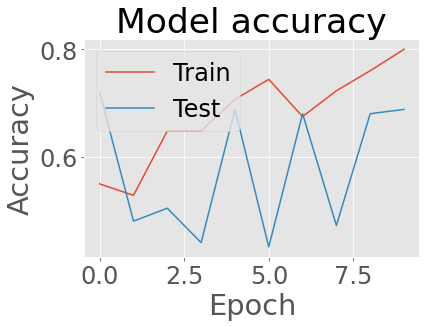

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

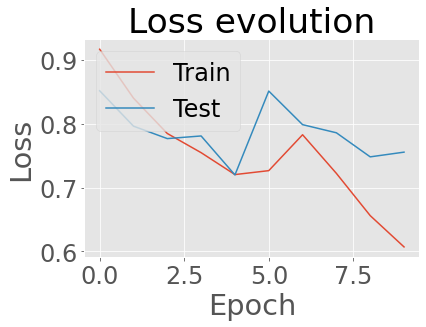

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

125/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

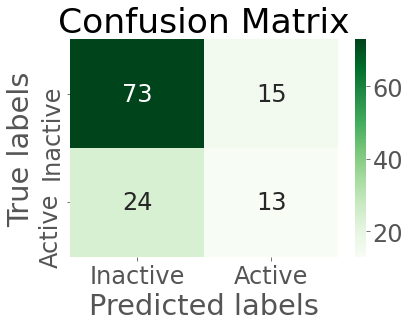

In [91]:
results = model_small_dataset.evaluate(val_data, val_labels)
predictions = model_small_dataset.predict(val_data)
print_metrics(predictions, val_labels)
plot_confusion(predictions, val_labels)

125/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

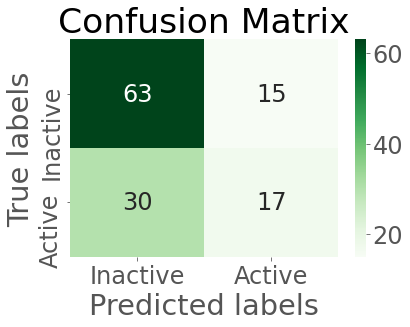

In [92]:
results = model_small_dataset.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data)
predictions = model_small_dataset.predict(mini_testing_2c9_data)
print_metrics(predictions, mini_labels_testing_2c9_data)
plot_confusion(predictions, mini_labels_testing_2c9_data)

In [77]:
%tensorboard --logdir logs/fit/rdkit_mordred_Mix_norm_6060_feature_selection

Reusing TensorBoard on port 6009 (pid 88250), started 2:41:06 ago. (Use '!kill 88250' to kill it.)

### 7.1.) Cross Validation

Based on [Manual k-Fold Cross Validation](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/).

This methodology provides a robust estimation of the performance of a model on unseen data. It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset.

In the example below we use the handy StratifiedKFold class from the scikit-learn Python machine learning library to split up the training dataset into 10 folds. The folds are stratified, meaning that the algorithm attempts to balance the number of instances of each class in each fold.


**Update**

With the new version, `plot_results_CV()` can print boxplot even if there is some nan value in the list.

In [38]:
def run_cross_validation(layers_dim, lr, dropout, optimizer, L2, train_val_data, train_val_labels, test_data, test_labels, folds=10, seed=1):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    MCCs_train, MCCs_val, MCCs_test = [],[],[]
    accs_train, accs_val, accs_test = [],[],[]
    recall_train, recall_val, recall_test = [],[],[]
    precision_train, precision_val, precision_test = [],[],[]
    actives_train, actives_val, actives_test = [],[],[]
    best_model = None
    best_model_MCC = -2
    best_model_ind = 0
    testset_size = int(train_val_data.shape[0]/folds)
    
    if not testset_size == test_data.shape[0]:
        test_data, test_labels = split_test_data(test_data, test_labels, testset_size, seed=seed)
    
    for i, (train_index, val_index) in enumerate(skf.split(train_val_data, train_val_labels)):
        train_data, val_data = train_val_data[train_index], train_val_data[val_index]
        train_labels, val_labels = train_val_labels[train_index], train_val_labels[val_index]
        actives_train.append(sum(train_labels))
        actives_val.append(sum(val_labels))
        actives_test.append(sum(test_labels))
        print(f"Calculating with fold {i}")
        
        model = generate_model(layers_dim, lr, dropout, optimizer, L2)
        history = model.fit(train_data, train_labels, epochs=10, verbose=2, validation_data = (val_data, val_labels), class_weight=class_weight)
      
        pred_train = model.predict(train_data)
        dict_train = print_metrics(pred_train, train_labels)
        train_acc, train_mcc, train_recall, train_precision = dict_train['accuracy'], dict_train['mcc'],  dict_train['recall'],  dict_train['precision']

        pred_val = model.predict(val_data)
        print(f"---> Validation set fold {i}")
        dict_val = print_metrics(pred_val, val_labels)
        val_acc, val_mcc, val_recall, val_precision = dict_val['accuracy'], dict_val['mcc'],  dict_val['recall'],  dict_val['precision']
        plot_confusion(pred_val, val_labels)
        
        predictions = model.predict(test_data)
        print(f"---> Test set fold {i}")
        dict_test = print_metrics(predictions, test_labels)
        test_acc, test_mcc, test_recall, test_precision = dict_test['accuracy'], dict_test['mcc'],  dict_test['recall'],  dict_test['precision']
        plot_confusion(predictions, test_labels)
        
        if test_mcc > best_model_MCC:
            best_model = model
            best_model_MCC = test_mcc
            best_model_ind = i
        MCCs_train.append(train_mcc)
        MCCs_val.append(val_mcc)
        MCCs_test.append(test_mcc)
        accs_train.append(train_acc)
        accs_val.append(val_acc)
        accs_test.append(test_acc)
        recall_train.append(train_recall)
        recall_val.append(val_recall)
        recall_test.append(test_recall)
        precision_train.append(train_precision)
        precision_val.append(val_precision)
        precision_test.append(test_precision)
    print(f"Best model was obtained from fold {best_model_ind} with MCC {best_model_MCC}")
    for i, (train_index, test_index) in enumerate(skf.split(train_val_data, train_val_labels)):
        print(f"Calculating with fold {i}")
        train_data, val_data = train_val_data[train_index], train_val_data[val_index]
        train_labels, val_labels = train_val_labels[train_index], train_val_labels[val_index]
        
        pred_val = best_model.predict(val_data)
        print(f"---> Validation set fold {i}")
        print_metrics(pred_val, val_labels)
        plot_confusion(pred_val, val_labels)
        
        predictions = best_model.predict(test_data)
        print(f"---> Test set fold {i}")
        print_metrics(predictions, test_labels)
        plot_confusion(predictions, test_labels)
    return (MCCs_train, MCCs_val, MCCs_test, accs_train, accs_val, accs_test, actives_train, actives_val, actives_test, recall_train, recall_val, recall_test, precision_train, precision_val, precision_test), best_model

def plot_results_CV(MCCs_train, MCCs_val, MCCs_test, accs_train, accs_val, accs_test, actives_train, actives_val, actives_test, recall_train, recall_val, recall_test, precision_train, precision_val, precision_test):
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    y_min = -0.1+np.nanmin([np.nanmin(accs_train), np.nanmin(accs_val),np.nanmin(accs_test), np.nanmin(MCCs_train), np.nanmin(MCCs_val), np.nanmin(MCCs_test), np.nanmin(recall_train), np.nanmin(recall_val), np.nanmin(recall_test), np.nanmin(precision_train), np.nanmin(precision_val), np.nanmin(precision_test)])
    y_max = 0.1+np.nanmax([np.nanmax(accs_train), np.nanmax(accs_val), np.nanmax(accs_test), np.nanmax(MCCs_train), np.nanmax(MCCs_val), np.nanmax(MCCs_test), np.nanmax(recall_train), np.nanmax(recall_val), np.nanmax(recall_test), np.nanmax(precision_train), np.nanmax(precision_val), np.nanmax(precision_test)])
    ax[0, 0].boxplot([np.array(accs_train)[~np.isnan(accs_train)], np.array(accs_val)[~np.isnan(accs_val)], np.array(accs_test)[~np.isnan(accs_test)]], labels=["Train", "Val" , "Test"])
    ax[0, 1].boxplot([np.array(MCCs_train)[~np.isnan(MCCs_train)], np.array(MCCs_val)[~np.isnan(MCCs_val)], np.array(MCCs_test)[~np.isnan(MCCs_test)]], labels=["Train", "Val", "Test"])
    ax[0, 2].boxplot([np.array(actives_train)[~np.isnan(actives_train)], np.array(actives_val)[~np.isnan(actives_val)], np.array(actives_test)[~np.isnan(actives_test)]], labels=["Train", "Val", "Test"])
    ax[1, 0].boxplot([np.array(recall_train)[~np.isnan(recall_train)], np.array(recall_val)[~np.isnan(recall_val)], np.array(recall_test)[~np.isnan(recall_test)]], labels=["Train", "Val" , "Test"])
    ax[1, 1].boxplot([np.array(precision_train)[~np.isnan(precision_train)], np.array(precision_val)[~np.isnan(precision_val)], np.array(precision_test)[~np.isnan(precision_test)]], labels=["Train", "Val", "Test"]) 
    ax[0, 0].set_ylim(top=y_max, bottom=y_min)
    ax[0, 1].set_ylim(top=y_max, bottom=y_min)
    ax[1, 0].set_ylim(top=y_max, bottom=y_min)
    ax[1, 1].set_ylim(top=y_max, bottom=y_min)
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 1].set_ylabel("MCC")
    ax[0, 2].set_ylabel("Actives proportion")
    ax[1, 0].set_ylabel("Recall")
    ax[1, 1].set_ylabel("Precision")
    plt.tight_layout()
    plt.show()

In [39]:
train_val_data = np.concatenate((train_data, val_data), axis=0)
train_val_labels = np.concatenate((train_labels, val_labels), axis=0)

print(train_val_data.shape, train_val_labels.shape)

(500, 1679) (500,)


Calculating with fold 0
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 10s - loss: 0.8375 - accuracy: 0.5511 - precision: 0.3189 - recall: 0.4370 - val_loss: 0.8167 - val_accuracy: 0.4000 - val_precision: 0.3095 - val_recall: 0.9286
Epoch 2/10
450/450 - 1s - loss: 0.8398 - accuracy: 0.4889 - precision: 0.3297 - recall: 0.6815 - val_loss: 0.8117 - val_accuracy: 0.6000 - val_precision: 0.3636 - val_recall: 0.5714
Epoch 3/10
450/450 - 1s - loss: 0.8240 - accuracy: 0.5289 - precision: 0.3514 - recall: 0.6741 - val_loss: 0.8087 - val_accuracy: 0.7400 - val_precision: 0.5556 - val_recall: 0.3571
Epoch 4/10
450/450 - 1s - loss: 0.8317 - accuracy: 0.5422 - precision: 0.3436 - recall: 0.5778 - val_loss: 0.7994 - val_accuracy: 0.6600 - val_precision: 0.4211 - val_recall: 0.5714
Epoch 5/10
450/450 - 1s - loss: 0.8186 - accuracy: 0.5622 - precision: 0.3719 - recall: 0.6667 - val_loss: 0.7927 - val_accuracy: 0.7600 - val_precision: 0.5833 - val_recall: 0.5000
Epoch 6/10
450/450 -

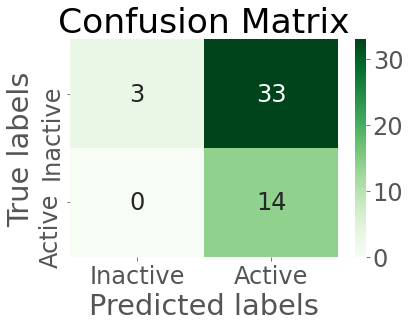

---> Test set fold 0
NER: 0.528, Sensitivity or recall: 1.000, Specificity: 0.056, Precision: 0.292, Correctly calssified: 0.320, MCC: 0.127


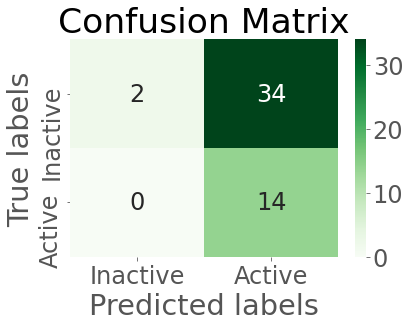

Calculating with fold 1
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8440 - accuracy: 0.6711 - precision_1: 0.3833 - recall_1: 0.1716 - val_loss: 0.8494 - val_accuracy: 0.6400 - val_precision_1: 0.2857 - val_recall_1: 0.1333
Epoch 2/10
450/450 - 1s - loss: 0.8484 - accuracy: 0.6156 - precision_1: 0.2329 - recall_1: 0.1269 - val_loss: 0.8459 - val_accuracy: 0.3800 - val_precision_1: 0.2333 - val_recall_1: 0.4667
Epoch 3/10
450/450 - 1s - loss: 0.8358 - accuracy: 0.5844 - precision_1: 0.3568 - recall_1: 0.4925 - val_loss: 0.8428 - val_accuracy: 0.4600 - val_precision_1: 0.3235 - val_recall_1: 0.7333
Epoch 4/10
450/450 - 1s - loss: 0.8377 - accuracy: 0.6044 - precision_1: 0.3764 - recall_1: 0.5000 - val_loss: 0.8443 - val_accuracy: 0.4200 - val_precision_1: 0.2941 - val_recall_1: 0.6667
Epoch 5/10
450/450 - 1s - loss: 0.8400 - accuracy: 0.5822 - precision_1: 0.3412 - recall_1: 0.4328 - val_loss: 0.8458 - val_accuracy: 0.5200 - val_precision_1: 0.3548 - va

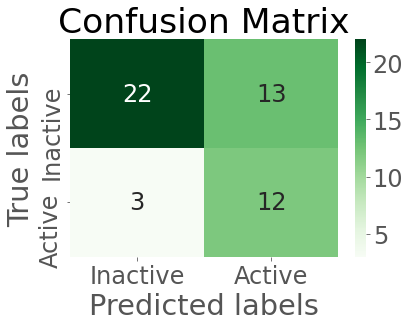

---> Test set fold 1
NER: 0.698, Sensitivity or recall: 0.786, Specificity: 0.611, Precision: 0.440, Correctly calssified: 0.660, MCC: 0.356


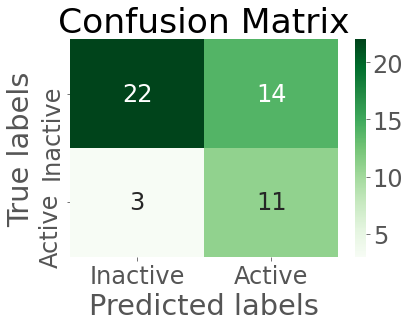

Calculating with fold 2
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 0.8483 - accuracy: 0.3800 - precision_2: 0.2591 - recall_2: 0.5821 - val_loss: 0.8446 - val_accuracy: 0.3000 - val_precision_2: 0.2619 - val_recall_2: 0.7333
Epoch 2/10
450/450 - 1s - loss: 0.8457 - accuracy: 0.4356 - precision_2: 0.3204 - recall_2: 0.7985 - val_loss: 0.8433 - val_accuracy: 0.4600 - val_precision_2: 0.3235 - val_recall_2: 0.7333
Epoch 3/10
450/450 - 1s - loss: 0.8403 - accuracy: 0.4422 - precision_2: 0.3043 - recall_2: 0.6791 - val_loss: 0.8437 - val_accuracy: 0.6200 - val_precision_2: 0.4091 - val_recall_2: 0.6000
Epoch 4/10
450/450 - 1s - loss: 0.8376 - accuracy: 0.4511 - precision_2: 0.3085 - recall_2: 0.6791 - val_loss: 0.8432 - val_accuracy: 0.3800 - val_precision_2: 0.3095 - val_recall_2: 0.8667
Epoch 5/10
450/450 - 1s - loss: 0.8446 - accuracy: 0.4244 - precision_2: 0.2807 - recall_2: 0.5970 - val_loss: 0.8426 - val_accuracy: 0.3600 - val_precision_2: 0.3023 - va

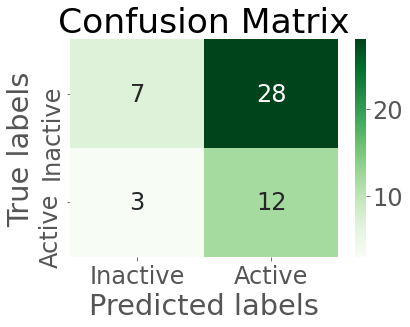

---> Test set fold 2
NER: 0.520, Sensitivity or recall: 0.929, Specificity: 0.111, Precision: 0.289, Correctly calssified: 0.340, MCC: 0.059


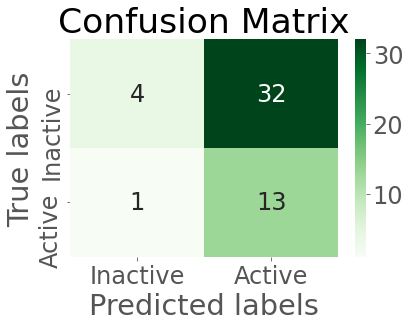

Calculating with fold 3
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8655 - accuracy: 0.6867 - precision_3: 0.2308 - recall_3: 0.0224 - val_loss: 0.8463 - val_accuracy: 0.7000 - val_precision_3: 0.5000 - val_recall_3: 0.0667
Epoch 2/10
450/450 - 1s - loss: 0.8452 - accuracy: 0.6600 - precision_3: 0.2889 - recall_3: 0.0970 - val_loss: 0.8425 - val_accuracy: 0.5200 - val_precision_3: 0.3448 - val_recall_3: 0.6667
Epoch 3/10
450/450 - 1s - loss: 0.8393 - accuracy: 0.6022 - precision_3: 0.3469 - recall_3: 0.3806 - val_loss: 0.8406 - val_accuracy: 0.5800 - val_precision_3: 0.3750 - val_recall_3: 0.6000
Epoch 4/10
450/450 - 1s - loss: 0.8412 - accuracy: 0.6111 - precision_3: 0.3525 - recall_3: 0.3657 - val_loss: 0.8411 - val_accuracy: 0.5000 - val_precision_3: 0.3438 - val_recall_3: 0.7333
Epoch 5/10
450/450 - 1s - loss: 0.8338 - accuracy: 0.6022 - precision_3: 0.3636 - recall_3: 0.4478 - val_loss: 0.8382 - val_accuracy: 0.5400 - val_precision_3: 0.3571 - va

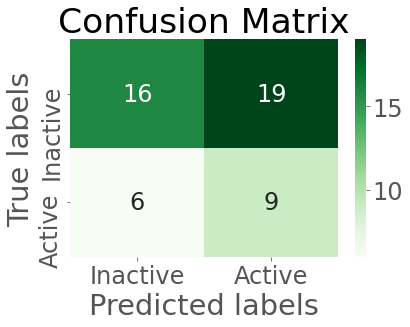

---> Test set fold 3
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


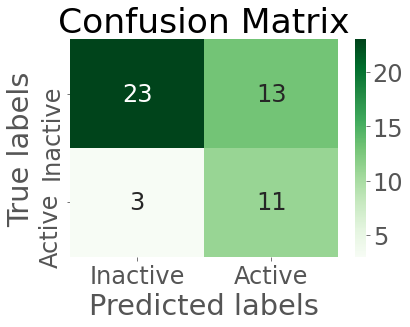

Calculating with fold 4
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8408 - accuracy: 0.4800 - precision_4: 0.2984 - recall_4: 0.5522 - val_loss: 0.8426 - val_accuracy: 0.5200 - val_precision_4: 0.3043 - val_recall_4: 0.4667
Epoch 2/10
450/450 - 1s - loss: 0.8345 - accuracy: 0.5444 - precision_4: 0.3476 - recall_4: 0.6045 - val_loss: 0.8399 - val_accuracy: 0.5400 - val_precision_4: 0.3333 - val_recall_4: 0.5333
Epoch 3/10
450/450 - 1s - loss: 0.8422 - accuracy: 0.5578 - precision_4: 0.3415 - recall_4: 0.5224 - val_loss: 0.8401 - val_accuracy: 0.5600 - val_precision_4: 0.3478 - val_recall_4: 0.5333
Epoch 4/10
450/450 - 1s - loss: 0.8408 - accuracy: 0.5156 - precision_4: 0.3019 - recall_4: 0.4776 - val_loss: 0.8387 - val_accuracy: 0.5400 - val_precision_4: 0.3333 - val_recall_4: 0.5333
Epoch 5/10
450/450 - 1s - loss: 0.8311 - accuracy: 0.4956 - precision_4: 0.3086 - recall_4: 0.5597 - val_loss: 0.8262 - val_accuracy: 0.4600 - val_precision_4: 0.3500 - va

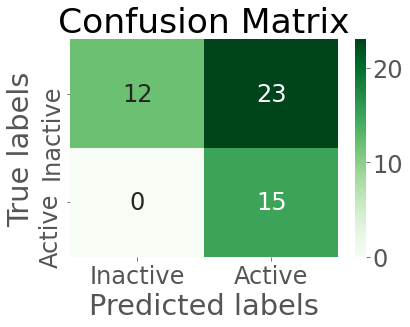

---> Test set fold 4
NER: 0.506, Sensitivity or recall: 0.929, Specificity: 0.083, Precision: 0.283, Correctly calssified: 0.320, MCC: 0.020


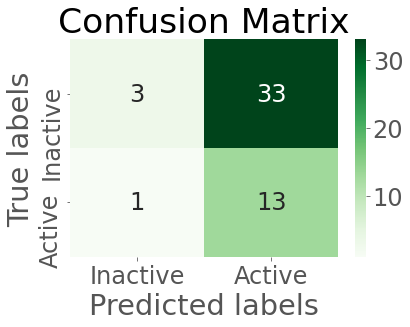

Calculating with fold 5
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8589 - accuracy: 0.6467 - precision_5: 0.2549 - recall_5: 0.0970 - val_loss: 0.8429 - val_accuracy: 0.5800 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/10
450/450 - 1s - loss: 0.8455 - accuracy: 0.6222 - precision_5: 0.2907 - recall_5: 0.1866 - val_loss: 0.8405 - val_accuracy: 0.6600 - val_precision_5: 0.3333 - val_recall_5: 0.1333
Epoch 3/10
450/450 - 1s - loss: 0.8391 - accuracy: 0.6333 - precision_5: 0.3133 - recall_5: 0.1940 - val_loss: 0.8408 - val_accuracy: 0.6600 - val_precision_5: 0.3750 - val_recall_5: 0.2000
Epoch 4/10
450/450 - 1s - loss: 0.8326 - accuracy: 0.6422 - precision_5: 0.3920 - recall_5: 0.3657 - val_loss: 0.8449 - val_accuracy: 0.3400 - val_precision_5: 0.3125 - val_recall_5: 1.0000
Epoch 5/10
450/450 - 1s - loss: 0.8411 - accuracy: 0.5289 - precision_5: 0.3194 - recall_5: 0.5149 - val_loss: 0.8346 - val_accuracy: 0.5000 - val_precision_5: 0.3

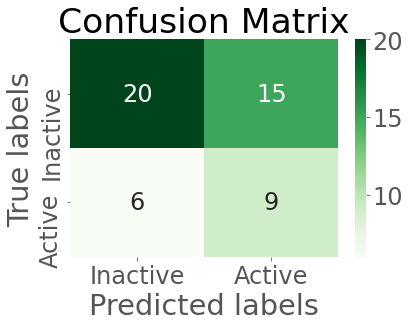

---> Test set fold 5
NER: 0.621, Sensitivity or recall: 0.714, Specificity: 0.528, Precision: 0.370, Correctly calssified: 0.580, MCC: 0.218


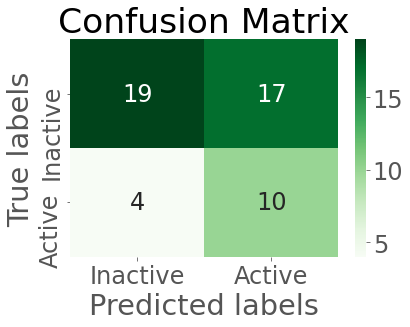

Calculating with fold 6
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 6s - loss: 0.8409 - accuracy: 0.5956 - precision_6: 0.2818 - recall_6: 0.2313 - val_loss: 0.8348 - val_accuracy: 0.6200 - val_precision_6: 0.4091 - val_recall_6: 0.6000
Epoch 2/10
450/450 - 1s - loss: 0.8425 - accuracy: 0.5667 - precision_6: 0.3106 - recall_6: 0.3731 - val_loss: 0.8354 - val_accuracy: 0.6400 - val_precision_6: 0.4000 - val_recall_6: 0.4000
Epoch 3/10
450/450 - 1s - loss: 0.8469 - accuracy: 0.5089 - precision_6: 0.2395 - recall_6: 0.2985 - val_loss: 0.8340 - val_accuracy: 0.6400 - val_precision_6: 0.4400 - val_recall_6: 0.7333
Epoch 4/10
450/450 - 1s - loss: 0.8328 - accuracy: 0.6044 - precision_6: 0.3764 - recall_6: 0.5000 - val_loss: 0.8313 - val_accuracy: 0.5000 - val_precision_6: 0.3529 - val_recall_6: 0.8000
Epoch 5/10
450/450 - 1s - loss: 0.8399 - accuracy: 0.5644 - precision_6: 0.2847 - recall_6: 0.3060 - val_loss: 0.8315 - val_accuracy: 0.5400 - val_precision_6: 0.3750 - va

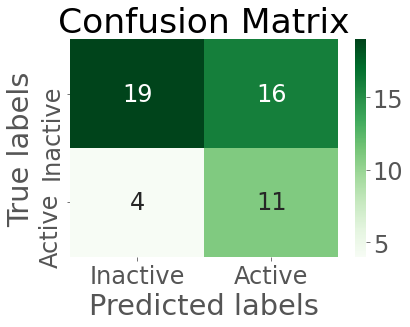

---> Test set fold 6
NER: 0.617, Sensitivity or recall: 0.929, Specificity: 0.306, Precision: 0.342, Correctly calssified: 0.480, MCC: 0.246


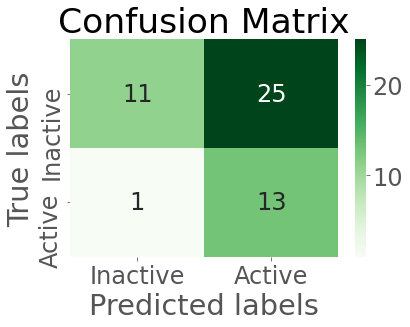

Calculating with fold 7
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 5s - loss: 0.8508 - accuracy: 0.3644 - precision_7: 0.2791 - recall_7: 0.7164 - val_loss: 0.8473 - val_accuracy: 0.2800 - val_precision_7: 0.2857 - val_recall_7: 0.9333
Epoch 2/10
450/450 - 1s - loss: 0.8392 - accuracy: 0.3511 - precision_7: 0.2985 - recall_7: 0.8731 - val_loss: 0.8407 - val_accuracy: 0.3200 - val_precision_7: 0.2979 - val_recall_7: 0.9333
Epoch 3/10
450/450 - 1s - loss: 0.8518 - accuracy: 0.3489 - precision_7: 0.2913 - recall_7: 0.8284 - val_loss: 0.8383 - val_accuracy: 0.3800 - val_precision_7: 0.3182 - val_recall_7: 0.9333
Epoch 4/10
450/450 - 1s - loss: 0.8428 - accuracy: 0.4067 - precision_7: 0.3061 - recall_7: 0.7836 - val_loss: 0.8379 - val_accuracy: 0.4400 - val_precision_7: 0.3415 - val_recall_7: 0.9333
Epoch 5/10
450/450 - 1s - loss: 0.8357 - accuracy: 0.4378 - precision_7: 0.3169 - recall_7: 0.7687 - val_loss: 0.8367 - val_accuracy: 0.3800 - val_precision_7: 0.3182 - va

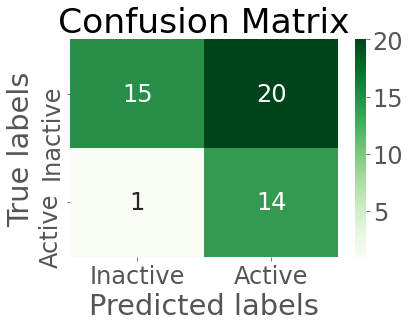

---> Test set fold 7
NER: 0.631, Sensitivity or recall: 0.929, Specificity: 0.333, Precision: 0.351, Correctly calssified: 0.500, MCC: 0.268


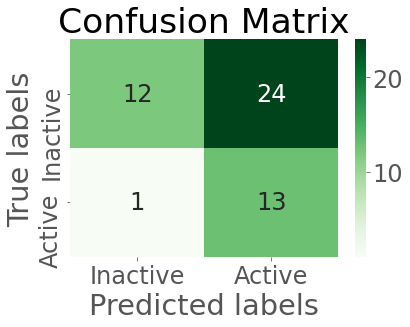

Calculating with fold 8
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 4s - loss: 0.8382 - accuracy: 0.5578 - precision_8: 0.3399 - recall_8: 0.5149 - val_loss: 0.8521 - val_accuracy: 0.4000 - val_precision_8: 0.1053 - val_recall_8: 0.1333
Epoch 2/10
450/450 - 1s - loss: 0.8431 - accuracy: 0.5400 - precision_8: 0.3005 - recall_8: 0.4104 - val_loss: 0.8460 - val_accuracy: 0.4400 - val_precision_8: 0.2759 - val_recall_8: 0.5333
Epoch 3/10
450/450 - 1s - loss: 0.8364 - accuracy: 0.5311 - precision_8: 0.3209 - recall_8: 0.5149 - val_loss: 0.8369 - val_accuracy: 0.3800 - val_precision_8: 0.3261 - val_recall_8: 1.0000
Epoch 4/10
450/450 - 1s - loss: 0.8367 - accuracy: 0.4200 - precision_8: 0.3070 - recall_8: 0.7537 - val_loss: 0.8377 - val_accuracy: 0.4000 - val_precision_8: 0.3077 - val_recall_8: 0.8000
Epoch 5/10
450/450 - 1s - loss: 0.8337 - accuracy: 0.4622 - precision_8: 0.3269 - recall_8: 0.7612 - val_loss: 0.8356 - val_accuracy: 0.5600 - val_precision_8: 0.3600 - va

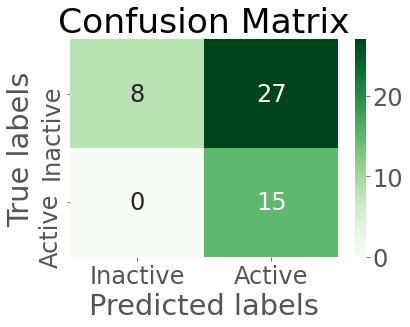

---> Test set fold 8
NER: 0.639, Sensitivity or recall: 1.000, Specificity: 0.278, Precision: 0.350, Correctly calssified: 0.480, MCC: 0.312


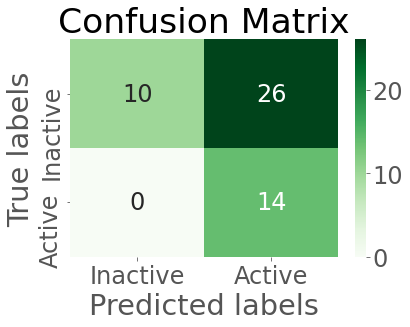

Calculating with fold 9
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 8s - loss: 0.8415 - accuracy: 0.5422 - precision_9: 0.3318 - recall_9: 0.5299 - val_loss: 0.8399 - val_accuracy: 0.5200 - val_precision_9: 0.3636 - val_recall_9: 0.8000
Epoch 2/10
450/450 - 1s - loss: 0.8415 - accuracy: 0.5178 - precision_9: 0.3052 - recall_9: 0.4851 - val_loss: 0.8373 - val_accuracy: 0.5200 - val_precision_9: 0.3714 - val_recall_9: 0.8667
Epoch 3/10
450/450 - 1s - loss: 0.8371 - accuracy: 0.5467 - precision_9: 0.3232 - recall_9: 0.4776 - val_loss: 0.8359 - val_accuracy: 0.4800 - val_precision_9: 0.3514 - val_recall_9: 0.8667
Epoch 4/10
450/450 - 1s - loss: 0.8401 - accuracy: 0.5222 - precision_9: 0.2965 - recall_9: 0.4403 - val_loss: 0.8350 - val_accuracy: 0.6400 - val_precision_9: 0.4348 - val_recall_9: 0.6667
Epoch 5/10
450/450 - 1s - loss: 0.8367 - accuracy: 0.5933 - precision_9: 0.3497 - recall_9: 0.4254 - val_loss: 0.8354 - val_accuracy: 0.4000 - val_precision_9: 0.3256 - va

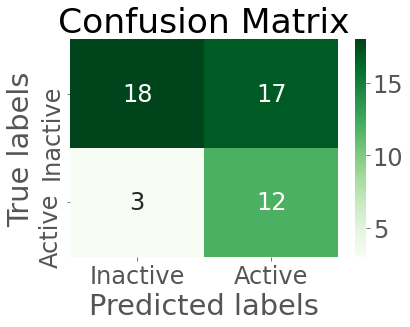

---> Test set fold 9
NER: 0.502, Sensitivity or recall: 0.643, Specificity: 0.361, Precision: 0.281, Correctly calssified: 0.440, MCC: 0.004


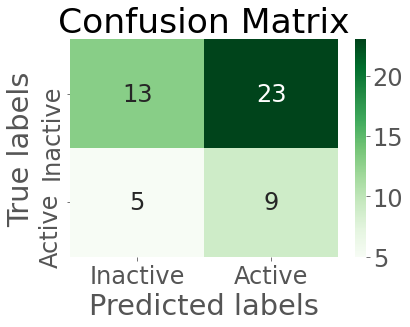

Best model was obtained from fold 3 with MCC 0.3815981058222307
Calculating with fold 0
---> Validation set fold 0
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


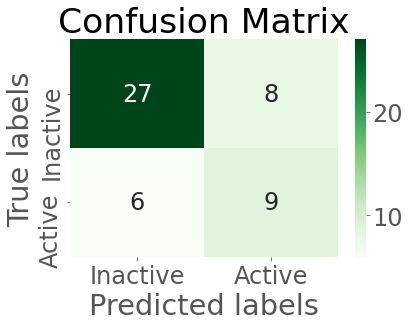

---> Test set fold 0
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


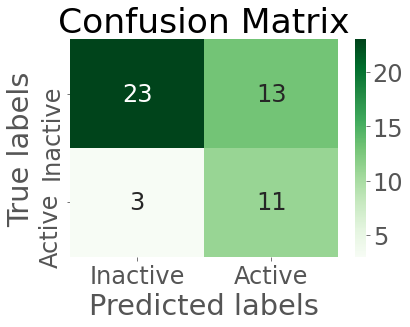

Calculating with fold 1
---> Validation set fold 1
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


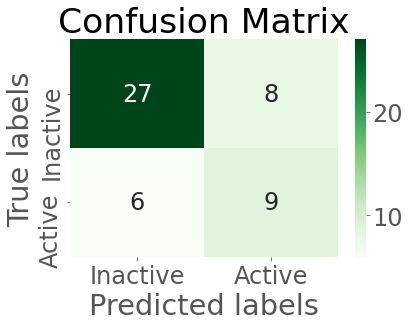

---> Test set fold 1
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


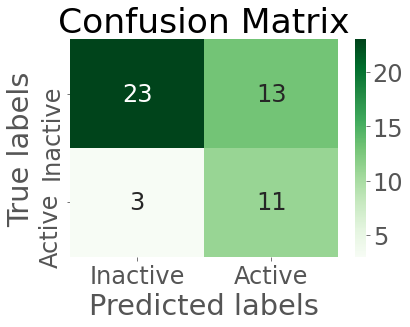

Calculating with fold 2
---> Validation set fold 2
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


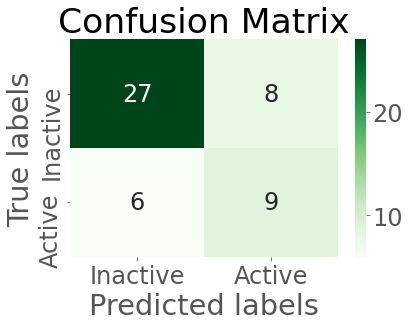

---> Test set fold 2
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


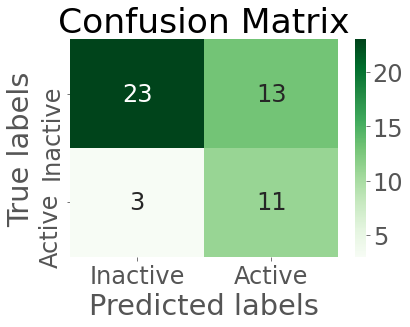

Calculating with fold 3
---> Validation set fold 3
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


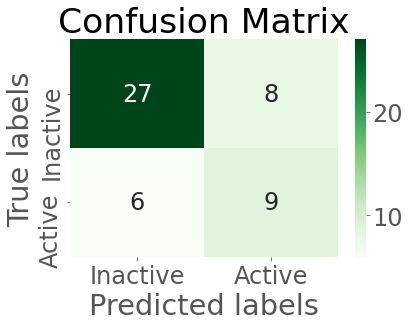

---> Test set fold 3
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


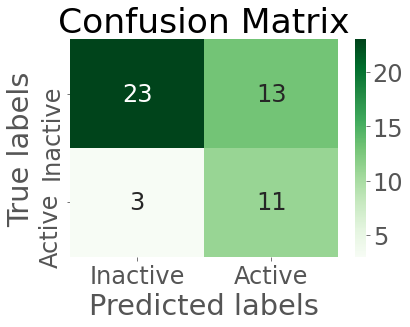

Calculating with fold 4
---> Validation set fold 4
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


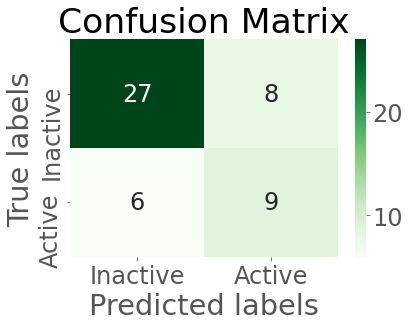

---> Test set fold 4
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


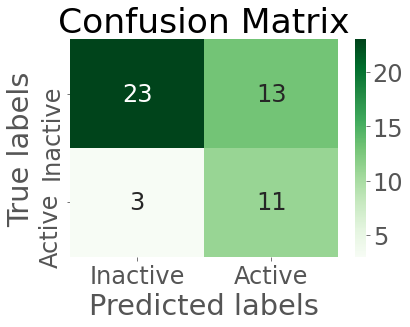

Calculating with fold 5
---> Validation set fold 5
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


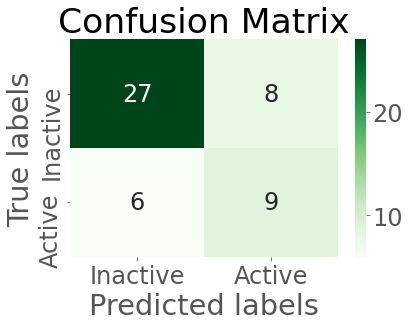

---> Test set fold 5
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


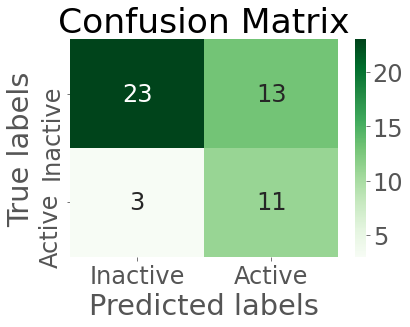

Calculating with fold 6
---> Validation set fold 6
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


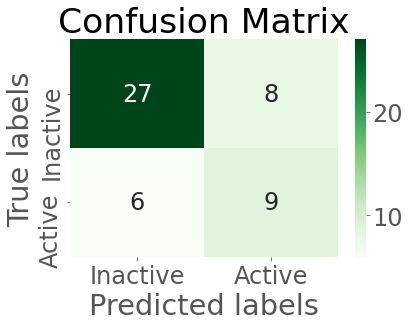

---> Test set fold 6
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


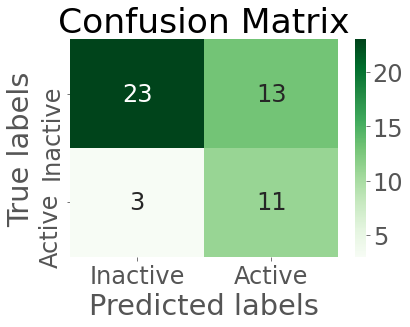

Calculating with fold 7
---> Validation set fold 7
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


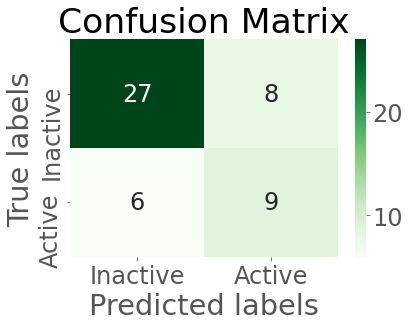

---> Test set fold 7
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


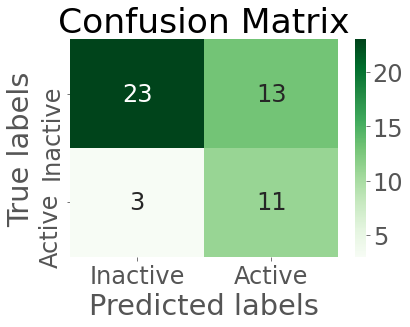

Calculating with fold 8
---> Validation set fold 8
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


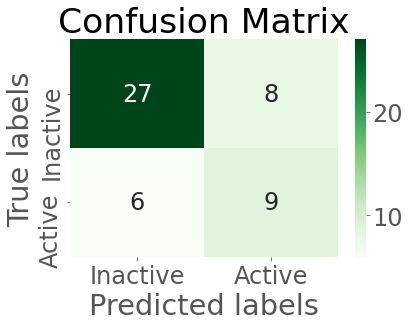

---> Test set fold 8
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


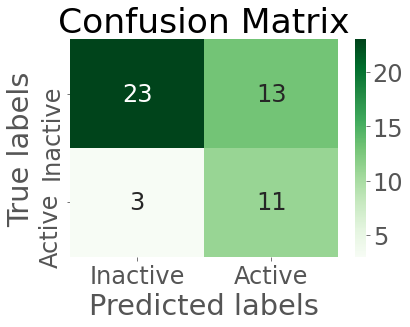

Calculating with fold 9
---> Validation set fold 9
NER: 0.686, Sensitivity or recall: 0.600, Specificity: 0.771, Precision: 0.529, Correctly calssified: 0.720, MCC: 0.359


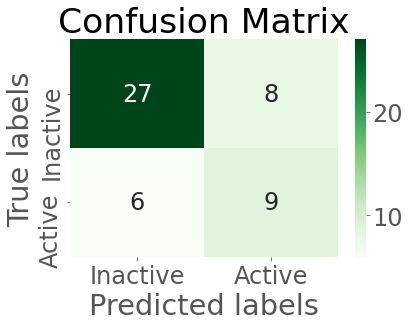

---> Test set fold 9
NER: 0.712, Sensitivity or recall: 0.786, Specificity: 0.639, Precision: 0.458, Correctly calssified: 0.680, MCC: 0.382


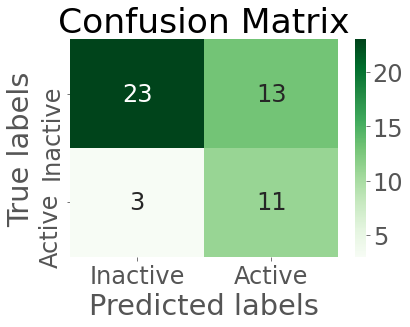

In [40]:
layers_dim = [train_data.shape[1],30,30,30,30, 1]
lr = 0.01
dropout = 0.2
optimizer = 'sgd'
L2 = 0.001

CV_parameters, best_model = run_cross_validation(layers_dim, lr, dropout, optimizer, L2, train_val_data, train_val_labels, mini_testing_2c9_data, mini_labels_testing_2c9_data, folds=10)

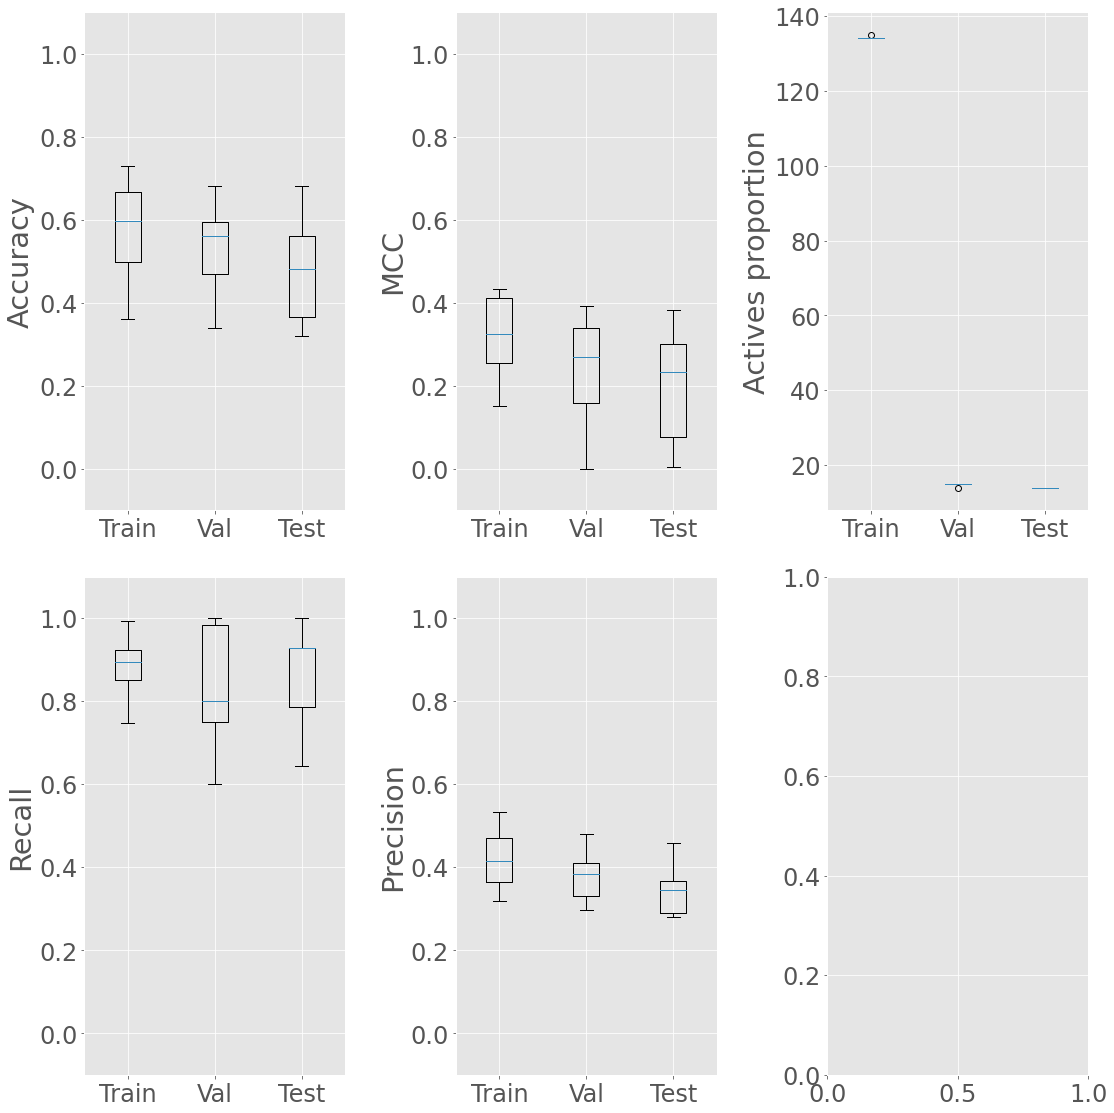

In [41]:
plot_results_CV(*CV_parameters)

### 7.2.) Tunning Hyperparameters


In [37]:
hyperparam_tunning = False

HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(3, 10))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete([i for i in range(10,151,20)]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))
N_BITS = train_data.shape[1]
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)
    _, results = model.evaluate(val_data, val_labels, verbose=0)                                                                                                
    _, results_val = model.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data, verbose=0)
    return results, results_val 


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy, accuracy_val = train_test_model(hparams)
    tf.summary.scalar("accuracy", accuracy, step=1)
    tf.summary.scalar("accuracy_val", accuracy_val, step=1)

In [ ]:
os.makedirs("hyperparameters_tunning/rdkit_mordred_Mix_norm_6060_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/rdkit_mordred_Mix_norm_6060_feature_selection').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy'), hp.Metric("accuracy_val", display_name="Validation_accuracy")]) 

In [42]:
%tensorboard --logdir hyperparameters_tunning/rdkit_mordred_Mix_norm_6060_feature_selection/logs/hparam_tuning/

In [40]:
if hyperparam_tunning:
    session_num = 0
    looping = list(product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values,[HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values))
    random.shuffle(looping)
    #looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    total_runs = len(list(looping))
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/rdkit_mordred_Mix_norm_6060_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

---Starting trial: run_0 of 3360
{'neurons': 30, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Train on 375 samples
Epoch 1/10
375/375 - 6s - loss: 0.8895 - accuracy: 0.6080
Epoch 2/10
375/375 - 1s - loss: 0.8558 - accuracy: 0.5813
Epoch 3/10
375/375 - 1s - loss: 0.8091 - accuracy: 0.5813
Epoch 4/10
375/375 - 1s - loss: 0.8057 - accuracy: 0.5787
Epoch 5/10
375/375 - 1s - loss: 0.6821 - accuracy: 0.7280
Epoch 6/10
375/375 - 1s - loss: 0.7343 - accuracy: 0.6773
Epoch 7/10
375/375 - 1s - loss: 0.6072 - accuracy: 0.7600
Epoch 8/10
375/375 - 1s - loss: 0.6345 - accuracy: 0.7360
Epoch 9/10
375/375 - 1s - loss: 0.5556 - accuracy: 0.7360
Epoch 10/10
375/375 - 1s - loss: 0.5766 - accuracy: 0.7707
---Starting trial: run_1 of 3360
{'neurons': 70, 'hidden_layers': 6, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 10.0}
Train on 375 samples
Epoch 1/10
375/375 - 3s - loss: nan - accuracy: 0.6373
Epoch 2/10
3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Anna/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-cf6dba6e1421>", line 21, in <module>
    run('hyperparameters_tunning/rdkit_mordred_Mix_norm_6060_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
  File "<ipython-input-37-6033f3c41ffa>", line 35, in run
    accuracy, accuracy_val = train_test_model(hparams)
  File "<ipython-input-37-6033f3c41ffa>", line 26, in train_test_model
    model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)
  File "/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "/U

TypeError: object of type 'NoneType' has no len()